In [1]:
from trajectree.fock_optics.utils import *
from trajectree.fock_optics.light_sources import *
from trajectree.fock_optics.devices import *
from trajectree.fock_optics.measurement import *
from trajectree.fock_optics.outputs import *
from trajectree.fock_optics.noise_models import *

from trajectree.trajectory import trajectory_evaluator

import time
import copy
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

/home/asingal/home/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/asingal/home/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
# params
trunc = 1
N = trunc+1
error_tolerance = 1e-12

mean_photon_num = (0.26)
efficiency = 1

num_simulations = 100
alice_angles = [np.pi/2, 0]
bob_angles = [np.pi/4, 3*np.pi/4]

depolarization_probabilities = [0.5] # np.linspace(0, 1, 10, endpoint=False) # np.linspace(0, 1, 2, endpoint=False) # np.linspace(0, 1, 30, endpoint=False)

In [3]:
from quimb.tensor import MatrixProductOperator as mpo #type: ignore
def create_perfect_bell_state(N=3, error_tolerance = 1e-10):
    # Defining the control and target inputs here
    a_dag = qt.create(N).full()
    I = qt.identity(N).full()

    a_H = np.kron(a_dag, I)
    a_V = np.kron(I, a_dag)

    # Testing the case with only one MPS for both control and target
    vacuum = create_vacuum_state(num_modes=4, N=N)
    # control_operator = 1/np.sqrt(3) * a_H + np.sqrt(2/3) * a_V
    pure_EPPS_operator = 1/sqrt(2) * (np.kron(a_H, a_H) + np.kron(a_V, a_V))
    pure_EPPS_operator_MPO = mpo.from_dense(pure_EPPS_operator, dims = N, sites = (0,1,2,3), L=4, tags="ideal_state")    
    psi = tensor_network_apply_op_vec(pure_EPPS_operator_MPO, vacuum, compress=True, contract = True, cutoff = error_tolerance)
    # read_quantum_state(psi, N, num_states = 2)
    return psi


def perform_simulation(N, num_simulations, quantum_channels, error_tolerance = 1e-10, track_dm = False):

    # Creating intial state here:
    num_modes = 8
    vacuum = create_vacuum_state(num_modes=num_modes, N=N)
    
    # psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
    psi = create_perfect_bell_state(N, error_tolerance)

    t_eval = trajectory_evaluator(quantum_channels)

    probabilities = []
    dm = 0

    for i in range(num_simulations): 
        start = time.time()
        psi_iter = copy.deepcopy(t_eval.perform_simulation(psi, error_tolerance, normalize = False))
        probabilities.append(psi_iter.normalize())
        if track_dm:
            dm += psi_iter.to_dense() @ psi_iter.to_dense().conj().T
        time_taken = time.time() - start

    if track_dm: 
        dm = dm/num_simulations
        return probabilities, dm

    return probabilities

vacuum = create_vacuum_state(num_modes=8, N=N)
site_tags = vacuum.site_tags


# Creating a list of lists where each sublsit contains the quantum channels for measuring one of the four observables (o_1 = x,z; o_2 = H, -XHX) for the corresponding polarization outcome being measured.  
coincidence_HH_ops_list = [rotate_and_measure(None, N, site_tags, 8, efficiency, error_tolerance, [idler], [signal], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {1:(0,2), 0:(1,3)}, return_MPOs = True) for idler in alice_angles for signal in bob_angles]
# Converting each of the set of operators in all the sublists into quantum channels. 
coincidence_HH_quantum_channels = [[quantum_channel(N = N, num_modes = 8, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in coincidence_HH_ops] for coincidence_HH_ops in coincidence_HH_ops_list]

# And the, doing this for all the possible polarization outcomes. 
coincidence_HV_ops_list = [rotate_and_measure(None, N, site_tags, 8, efficiency, error_tolerance, [idler], [signal], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {1:(0,3), 0:(1,2)}, return_MPOs = True) for idler in alice_angles for signal in bob_angles]
coincidence_HV_quantum_channels = [[quantum_channel(N = N, num_modes = 8, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in coincidence_HV_ops] for coincidence_HV_ops in coincidence_HV_ops_list]

coincidence_VH_ops_list = [rotate_and_measure(None, N, site_tags, 8, efficiency, error_tolerance, [idler], [signal], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {0:(0,3), 1:(1,2)}, return_MPOs = True) for idler in alice_angles for signal in bob_angles]
coincidence_VH_quantum_channels = [[quantum_channel(N = N, num_modes = 8, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in coincidence_VH_ops] for coincidence_VH_ops in coincidence_VH_ops_list]

coincidence_VV_ops_list = [rotate_and_measure(None, N, site_tags, 8, efficiency, error_tolerance, [idler], [signal], rotations = {"signal":(0,1), "idler":(2,3)}, measurements = {0:(0,2), 1:(1,3)}, return_MPOs = True) for idler in alice_angles for signal in bob_angles]
coincidence_VV_quantum_channels = [[quantum_channel(N = N, num_modes = 8, formalism = "closed", unitary_MPOs = PA_MPO) for PA_MPO in coincidence_VV_ops] for coincidence_VV_ops in coincidence_VV_ops_list]

<Compressed Sparse Row sparse array of dtype 'complex128'
	with 0 stored elements and shape (16, 16)>


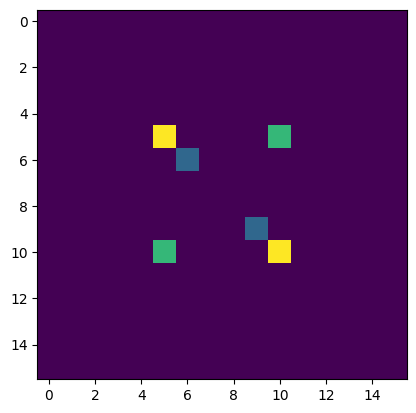

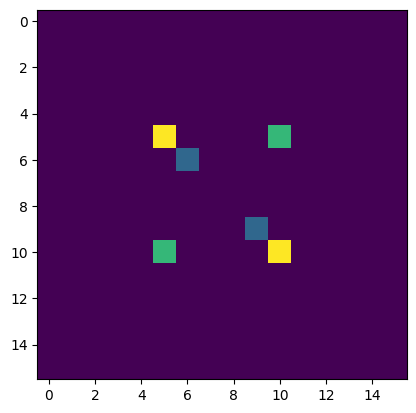

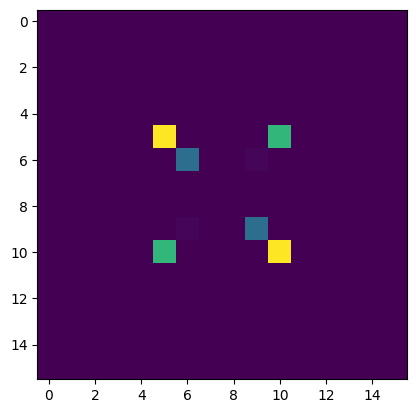

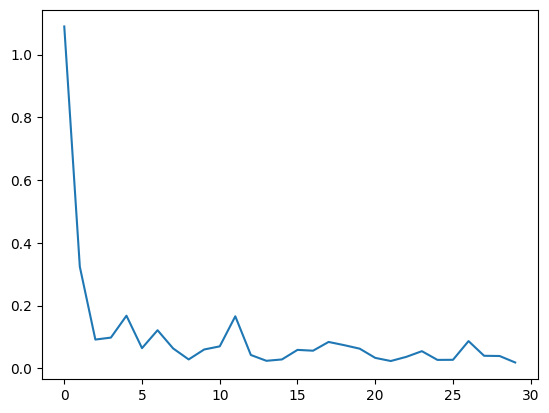

In [14]:
# Checking if the DMs match with what trajectree gives.
quantum_channel_list = []
depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = 0.5, N = N)
quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1,2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.

vacuum = create_vacuum_state(num_modes=8, N=N)
psi = create_perfect_bell_state(N, error_tolerance)

dm = psi.to_dense() @ psi.to_dense().conj().T
# print(len(dm))
direct_dm = 0
for i in depolarizing_kraus_ops:
    direct_dm += i @ dm @ i.conj().T
plt.figure()
plt.imshow(np.real(direct_dm))

# Trajectree dm
t_eval = trajectory_evaluator(quantum_channel_list)
trajectree_dm = t_eval.calculate_density_matrix(psi, error_tolerance)

plt.figure()
# print(np.real(np.round(dm, 3)))
plt.imshow(np.real(trajectree_dm))


sp.csr_array(trajectree_dm - direct_dm)
print(sp.csr_array(np.round(trajectree_dm - direct_dm, 10)))


# Estimating the dm using trajectree
num_simulations = 300

# The animation part is AI generated. 
fig, ax = plt.subplots()
ims = []
errors = []

for i in range(1, num_simulations, 10):
    probs, estimated_dm = perform_simulation(N, i, quantum_channel_list, track_dm = True)
    
    errors.append(np.linalg.norm(estimated_dm - direct_dm))

    im = ax.imshow(np.real(estimated_dm), animated=True)
    ims.append([im])

plt.figure()
plt.plot(errors)

ani = animation.ArtistAnimation(fig, ims)
display(HTML(ani.to_jshtml()))
ax.imshow(np.real(estimated_dm))

In [4]:
a_dag = qt.create(N).full()
I = qt.identity(N).full()

a_H = np.kron(a_dag, I)
a_V = np.kron(I, a_dag)

# Testing the case with only one MPS for both control and target
vacuum = create_vacuum_state(num_modes=2, N=N)
# control_operator = 1/np.sqrt(3) * a_H + np.sqrt(2/3) * a_V
pure_EPPS_operator = a_V

input = pure_EPPS_operator @ vacuum.to_dense()
print_quantum_state(N, sp.csr_array(input), num_states = 1, return_string = False)

depolarized = rx(np.pi, N, return_unitary=True) @ input
print_quantum_state(N, sp.csr_array(depolarized), num_states = 2, return_string = False)

# pure_EPPS_operator_MPO = mpo.from_dense(pure_EPPS_operator, dims = N, sites = (0,1), L=2, tags="ideal_state")    
# psi = tensor_network_apply_op_vec(pure_EPPS_operator_MPO, vacuum, compress=True, contract = True, cutoff = 1e-15)

# read_quantum_state(psi, N, num_states = 1)

# rotator_node_1 = generalized_mode_mixer(site1 = 0, site2 = 1, theta = np.pi/2, phi = 0, psi = 0, lamda = 0, total_sites = 2, N = N, tag = 'MM')

# idler_rotated_psi = tensor_network_apply_op_vec(rotator_node_1, psi, compress=True, contract = True, cutoff = 1e-15)
# read_quantum_state(idler_rotated_psi, N, num_states = 1)

# POVM_1_OPs = generate_sqrt_POVM_MPO(sites = (1,), outcome = 1, total_sites=2, efficiency=1, N=N, pnr = False)

# idler_rotated_psi = tensor_network_apply_op_vec(POVM_1_OPs[0], idler_rotated_psi, compress=True, contract = True, cutoff = 1e-15)
# read_quantum_state(idler_rotated_psi, N, num_states = 1)

# idler_rotated_psi.norm()**2

Corresponding Basis terms:
0H1V_A - 1 - [1.+0.j]
Corresponding Basis terms:
0H0V_B 1H0V_A - 2 - [0.-1.j]


[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.375  0.    -0.     0.     0.
   0.25   0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.125  0.     0.     0.
   0.    -0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.    -0.     0.     0.     0.     0.
  -0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.

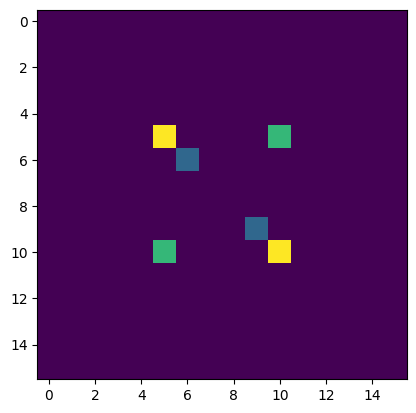

In [ ]:
CHSH_values = []

for depolarization_probability in depolarization_probabilities:
    quantum_channel_list = []
    # Add depolarizing noise source here:
      
    # depolarizing_kraus_ops = depolarizing_operators(depolarizing_probability = depolarization_probability, N = N)
    # quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.
    # quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.
    depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_probability, N = N)
    quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1,2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.

    coincidence_HH_list = [perform_simulation(N, num_simulations, quantum_channel_list+coincidence_HH_quantum_channel) for coincidence_HH_quantum_channel in coincidence_HH_quantum_channels]
    coincidence_HV_list = [perform_simulation(N, num_simulations, quantum_channel_list+coincidence_HV_quantum_channel) for coincidence_HV_quantum_channel in coincidence_HV_quantum_channels]
    coincidence_VH_list = [perform_simulation(N, num_simulations, quantum_channel_list+coincidence_VH_quantum_channel) for coincidence_VH_quantum_channel in coincidence_VH_quantum_channels]
    coincidence_VV_list = [perform_simulation(N, num_simulations, quantum_channel_list+coincidence_VV_quantum_channel) for coincidence_VV_quantum_channel in coincidence_VV_quantum_channels]


    expectation_values = np.array([np.mean(coincidence_HH_list, axis = 1),
                                   np.mean(coincidence_HV_list, axis = 1),
                                   np.mean(coincidence_VH_list, axis = 1),
                                   np.mean(coincidence_VV_list, axis = 1)])
    
    # print(expectation_values)

    # normalized_coincidences = [np.array([x[0], -x[1], -x[2], x[3]])/sum(x) for x in expectation_values.T]

    # print(normalized_coincidences)


    # coincidence_HH = np.mean(coincidence_HH_list, axis = 1)
    # coincidence_HV = -np.mean(coincidence_HV_list, axis = 1)
    # coincidence_VH = -np.mean(coincidence_VH_list, axis = 1)
    # coincidence_VV = np.mean(coincidence_VV_list, axis = 1)

    # probs_HH = [x for x in coincidence_HH]
    # probs_HV = [x for x in coincidence_HV]
    # probs_VH = [x for x in coincidence_VH]
    # probs_VV = [x for x in coincidence_VV]

    # expectations = [sum(x) for x in zip(probs_HH, probs_HV, probs_VH, probs_VV)]

    # expectations = [sum(x) for x in normalized_coincidences]

    expectations = [([x[0]-x[1]-x[2]+x[3]])/sum(x) for x in expectation_values.T]

    CHSH_values.append(np.abs(expectations[0] + expectations[1] + expectations[2] - expectations[3]))

[array([2.82842712]), array([2.81187252]), array([2.83467758]), array([2.8113453]), array([2.69626937]), array([2.73246364]), array([2.47584174]), array([2.28685866]), array([1.71047136]), array([0.71294568])]


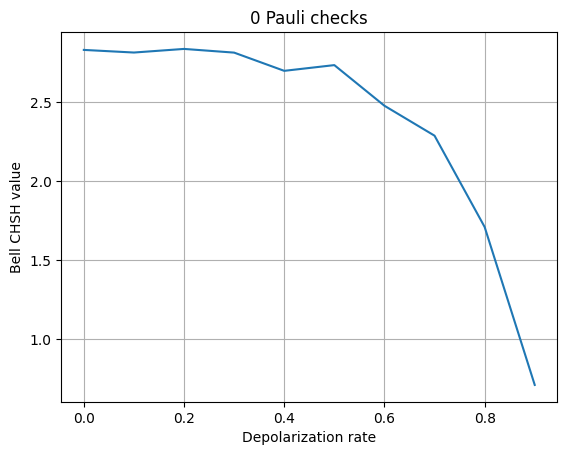

In [ ]:
~E Aq!~``

Corresponding Basis terms:
0H1V_B 0H1V_A - 5 - [0.70710678+0.j]
1H0V_B 1H0V_A - 10 - [0.70710678+0.j]


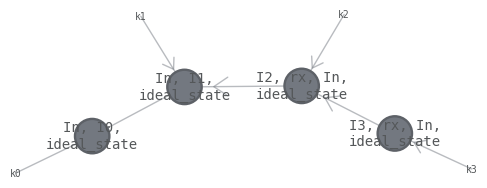

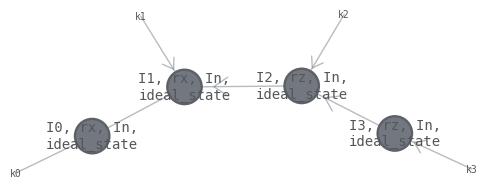

Corresponding Basis terms:
0H1V_B 1H0V_A - 6 - [-0.70710678-0.j]
1H0V_B 0H1V_A - 9 - [0.70710678+0.j]


checking all depolarizing ops
MatrixProductOperator([
    Tensor(shape=(2, 2, 1), inds=('k0', 'b0', '_9b19a9AAAii'), tags=oset(['I0', 'op']), left_inds=('k0', 'b0')),
    Tensor(shape=(1, 2, 2), inds=('_9b19a9AAAii', 'k1', 'b1'), tags=oset(['I1', 'op'])),
], tensors=2, indices=5, L=4, max_bond=1)
Corresponding Basis terms:
0H1V_B 0H1V_A - 5 - [0.5+0.j]
1H0V_B 1H0V_A - 10 - [0.5+0.j]
MatrixProductOperator([
    Tensor(shape=(2, 2, 4), inds=('k0', 'b0', '_9b19a9AAAij'), tags=oset(['I0', 'op']), left_inds=('k0', 'b0')),
    Tensor(shape=(4, 2, 2), inds=('_9b19a9AAAij', 'k1', 'b1'), tags=oset(['I1', 'op'])),
], tensors=2, indices=5, L=4, max_bond=4)
Corresponding Basis terms:
0H1V_B 1H0V_A - 6 - [0.-0.28867513j]
1H0V_B 0H1V_A - 9 - [0.-0.28867513j]
MatrixProductOperator([
    Tensor(shape=(2, 2, 4), inds=('k0', 'b0', '_9b19a9AAAik'), tags=oset(['I0', 'op']), left_inds=('k0', 'b0')),
    

In [13]:
from trajectree.trajectory import quantum_channel

depolarization_probability = 0.5

quantum_channel_list = []
# depolarizing_kraus_ops = two_qubit_depolarizing_channel(depolarizing_probability = depolarization_probability, N = N)
# quantum_channel_list.append(quantum_channel(N = N, num_modes = 8, formalism = "kraus", kraus_ops_tuple = ((0,1,2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.

depolarizing_kraus_ops = depolarizing_operators(depolarizing_probability = depolarization_probability, N = N)
quantum_channel_list.append(quantum_channel(N = N, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((0,1), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.
quantum_channel_list.append(quantum_channel(N = N, num_modes = 4, formalism = "kraus", kraus_ops_tuple = ((2,3), depolarizing_kraus_ops), name = "depolarization")) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.


rx_MPO = rx(np.pi, N, return_unitary = False, site1 = 2, site2 = 3, total_sites=4)
psi = create_perfect_bell_state(N=N)
read_quantum_state(psi, N, num_states = 2)
psi = tensor_network_apply_op_vec(rx_MPO, psi, compress=True, contract = True, cutoff = error_tolerance)
psi.draw()
# read_quantum_state(psi, N, num_states = 2)

psi = create_perfect_bell_state(N=N)
rx_MPO = rx(np.pi, N, return_unitary = False, site1 = 0, site2 = 1, total_sites=4)
psi = tensor_network_apply_op_vec(rx_MPO, psi, compress=True, contract = True, cutoff = error_tolerance)

rx_MPO = rz(np.pi, N, return_unitary = False, site1 = 2, site2 = 3, total_sites=4)
psi = tensor_network_apply_op_vec(rx_MPO, psi, compress=True, contract = True, cutoff = error_tolerance)

psi.draw()
read_quantum_state(psi, N, num_states = 2)

print("\n\nchecking all depolarizing ops")

for i in range(len(depolarizing_kraus_ops)):
    psi = create_perfect_bell_state(N=N)
    print(quantum_channel_list[0].get_MPOs()[i])
    psi = tensor_network_apply_op_vec(quantum_channel_list[0].get_MPOs()[i], psi, compress=True, contract = True, cutoff = error_tolerance)
    read_quantum_state(psi, N, num_states = 2)
for i in range(len(depolarizing_kraus_ops)):
    psi = create_perfect_bell_state(N=N)
    print(quantum_channel_list[1].get_MPOs()[i])
    psi = tensor_network_apply_op_vec(quantum_channel_list[1].get_MPOs()[i], psi, compress=True, contract = True, cutoff = error_tolerance)
    psi = tensor_network_apply_op_vec(quantum_channel_list[0].get_MPOs()[i], psi, compress=True, contract = True, cutoff = error_tolerance)
    read_quantum_state(psi, N, num_states = 2)
# perform_simulation(N, 50, quantum_channel_list)